In [67]:
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set()
import glob     
import numpy as np
import os
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from pre_process_data import convert_all_images_from_png_to_jpg, build_train_df, process_data, stratified_random_shuffle_sampler

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
import torch

# Load the data path to images
IMG_DIR = '../data/train'
LABEL_FILENAME = 'labels.csv'

# We will assume that all images are of .jpg or .png extensions

In [68]:
# convert any images that may be png
convert_all_images_from_png_to_jpg(IMG_DIR)
# generate train_df
train_df = build_train_df(IMG_DIR,LABEL_FILENAME)
print(train_df)
# show target names
CLASSES = list(train_df.category.unique())
print("Classes:", CLASSES)


No .png images found
           image  category
0    2788353.jpg         0
1    2782131.jpg         0
2    2884349.jpg         0
3    2900596.jpg         0
4    2841543.jpg         0
..           ...       ...
895  2804619.jpg         4
896  2829250.jpg         4
897  2825240.jpg         4
898  2825172.jpg         4
899  2847678.jpg         4

[900 rows x 2 columns]
           image
0    1003035.jpg
1    1005343.jpg
2    1008439.jpg
3    1015027.jpg
4    1056555.jpg
..           ...
895   964374.jpg
896   977738.jpg
897   980701.jpg
898   986137.jpg
899   997951.jpg

[900 rows x 1 columns]
           image  category
0    2788353.jpg         0
1    2782131.jpg         0
2    2884349.jpg         0
3    2900596.jpg         0
4    2841543.jpg         0
..           ...       ...
895  2804619.jpg         4
896  2829250.jpg         4
897  2825240.jpg         4
898  2825172.jpg         4
899  2847678.jpg         4

[900 rows x 2 columns]
Classes: [0, 1, 2, 3, 4]


In [76]:
# For using our pre-trained model VGG16, we need to ensure that we use the exact same pre-processing steps
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# We will process our data to ensure that the file format is appopropriate for pytorch's ImageFolder
if not 'processed_data' in next(os.walk(IMG_DIR))[1] or not CLASSES in next(os.walk(f"{IMG_DIR}/processed_data/"))[1]:
    process_data(train_df,IMG_DIR,CLASSES)

PROCESSED_DATA_PATH = f"{IMG_DIR}/processed_data/"
BATCH_SIZE = 64

# Load the training and validation dataset
train_dataset = datasets.ImageFolder(PROCESSED_DATA_PATH, transform=transform)
print(train_dataset)

# randomly split train and validation data, we could also do a simple splice of 0.5 train - 0.5 validate. 
train_sampler, valid_sampler = stratified_random_shuffle_sampler(train_dataset, test_size=0.3, shuffle=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, \
                              sampler=train_sampler)
valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, \
                              sampler=valid_sampler)
train_size =  len(train_sampler)
valid_size = len(valid_sampler)

c:\Users\USER\Anaconda3\envs\money\lib\site-packages\torchvision\transforms\transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
c:\Users\USER\Anaconda3\envs\money\lib\site-packages\torchvision\transforms\transforms.py:1376: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


set() {'1', '2', '0', '3', '4'}
Dataset ImageFolder
    Number of datapoints: 900
    Root location: ../data/train/processed_data/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               RandomAffine(degrees=[-40.0, 40.0], scale=(1, 2), shear=[-15.0, 15.0])
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


c:\Users\USER\Anaconda3\envs\money\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


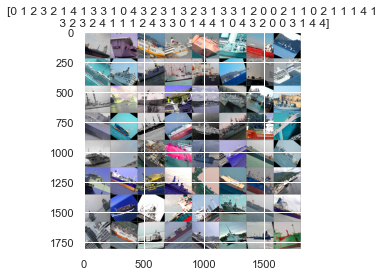

In [77]:
import torchvision
# Sample some of our training data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out,title=classes.numpy())

# Import and train model

In [78]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_ft = models.vgg16(pretrained=True)
print(model_ft)

cuda
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [79]:
def weight_builder(clss_lst,data_size):
  weights = []
  for clss in clss_lst:
    weights.append(len(glob.glob(f"{IMG_DIR}/{clss}"))/data_size)
  return weights

In [80]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [81]:
# Freeze model parameters
for param in model_ft.parameters():
    param.requires_grad = False

# Change the final layer of VGG16 Model for Transfer Learning
# Here the size of each output sample is set to 5
fc_inputs = model_ft.classifier[-4].out_features
model_ft.classifier[-1] = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(CLASSES))
)

# Enable GPU usage for model weights
model_ft = model_ft.to(device)
# Create weights to handle class imbalance
weights = weight_builder(CLASSES,train_size)
# Add early stopping as a regularizer for overfitting
early_stopping = EarlyStopping(tolerance=5, min_delta=10)
loss_fn = nn.CrossEntropyLoss()
# We will use ADAM as our opitimiser to learn the optimal amount of gradient descent
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
# Exponentially Decay LR by a factor of 0.1
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [82]:
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [83]:
import time
import copy
plot_train_acc = []
plot_train_loss = []
plot_val_acc = []
plot_val_loss = []
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=100):
    since = time.perf_counter()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_dataloader
                dataset_size = valid_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            if phase == 'train':
                plot_train_loss.append(float(epoch_loss))
                plot_train_acc.append(float(epoch_acc))
            if phase == 'val':
                plot_val_loss.append(float(epoch_loss))
                plot_val_acc.append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.perf_counter() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
model_ft = train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4005 Acc: 0.4079
val Loss: 1.0437 Acc: 0.6111

Epoch 1/24
----------
train Loss: 1.0399 Acc: 0.5873
val Loss: 0.8940 Acc: 0.6519

Epoch 2/24
----------
train Loss: 0.8518 Acc: 0.6714
val Loss: 0.8254 Acc: 0.7000

Epoch 3/24
----------
train Loss: 0.8783 Acc: 0.6683
val Loss: 0.7550 Acc: 0.7444

Epoch 4/24
----------
train Loss: 0.8665 Acc: 0.6714
val Loss: 0.8496 Acc: 0.6667

Epoch 5/24
----------
train Loss: 0.8539 Acc: 0.6540
val Loss: 0.7932 Acc: 0.6778

Epoch 6/24
----------
train Loss: 0.8499 Acc: 0.6841
val Loss: 0.8469 Acc: 0.7000

Epoch 7/24
----------
train Loss: 0.8134 Acc: 0.6889
val Loss: 0.8082 Acc: 0.6815

Epoch 8/24
----------
train Loss: 0.7614 Acc: 0.7159
val Loss: 0.7586 Acc: 0.7519

Epoch 9/24
----------
train Loss: 0.7598 Acc: 0.7175
val Loss: 0.7393 Acc: 0.7333

Epoch 10/24
----------
train Loss: 0.7624 Acc: 0.7190
val Loss: 0.7638 Acc: 0.7111

Epoch 11/24
----------
train Loss: 0.7197 Acc: 0.7333
val Loss: 0.7604 Acc: 0.7222

Ep

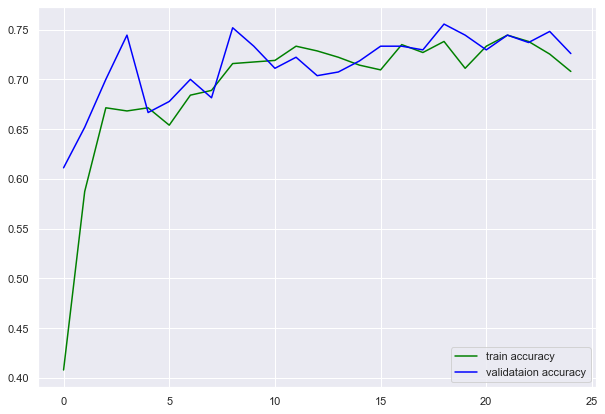

In [84]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('../images/train_val_accuracy.png')
plt.show()

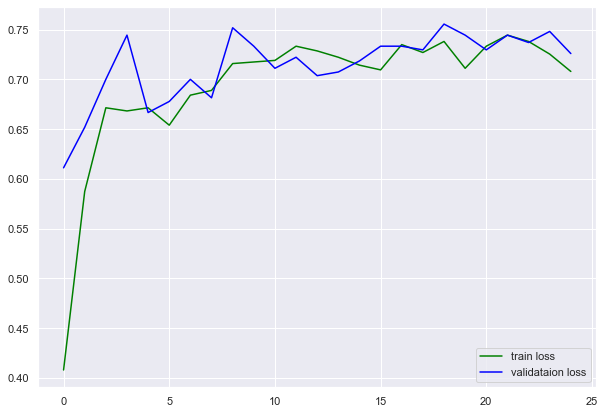

In [85]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train loss')
plt.plot(plot_val_acc, color='blue', label='validataion loss')
plt.legend()
plt.savefig('../images/train_val_loss.png')
plt.show()

In [86]:
torch.save(model_ft.state_dict(), 'VGG16_v2_train.pt')